# Importing all the required libraries

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
import torch
import numpy as np
from torchvision.utils import make_grid
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from IPython.display import Image
from skimage.io import imread,imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../Dataset/'
print(os.listdir(DATA_DIR))

['Data']


# Images, Display Functions, Data Set, Data Loader

In [3]:
image_size = 64 #Target image size
latent_size = 128 #Size of the latent vector
batch_size = 1 #Batch size
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #Mean and standard deviation of the dataset used to normalize to [-1,1]

In [4]:
train_dataset = ImageFolder(DATA_DIR, transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))
Train_DataLoader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

/home/salehahmad/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


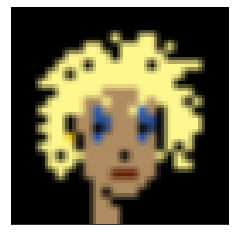

In [6]:
def show_images(images, num_max=batch_size):
    '''
    Function to show images in a grid
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:num_max]), nrow=batch_size).permute(1, 2, 0)) #permute to change the order of the axes i.e. from (C,H,W) to (H,W,C)
    
def show_batch(dataloader, num_max=batch_size):
    '''
    Function to show a batch of images from the dataloader
    '''
    for images, _ in dataloader:
        show_images(images, num_max)
        break

show_batch(Train_DataLoader)

In [7]:
def get_default_device():
    """
    Select GPU if available, else CPU
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    """
    Move tensors to chosen device
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DataLoaderDevice():
    """
    Wrap a dataloader to move data to a device
    """
    def __init__(self, dataloader, device):
        self.device = device
        self.dataloader = dataloader
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Count of batches"""
        return len(self.dataloader)

In [8]:
device = get_default_device()
print('The default device is:',device)

The default device is: cpu


In [9]:
Train_DataLoader = DataLoaderDevice(Train_DataLoader, device)

# GAN Architecture, Discriminator, Generator

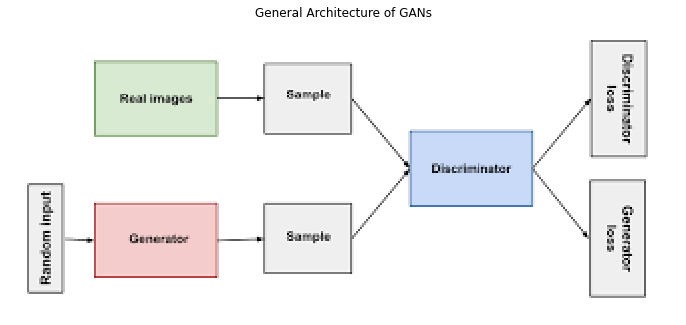

In [10]:
Architecture_GAN = imread('../GAN Architecture/Gan Architecture.png')
plt.figure(figsize=(10,10))
imshow(Architecture_GAN)
plt.axis('off')
plt.title('General Architecture of GANs')
plt.show()

In [11]:
discriminator = nn.Sequential(
    # in: batch_size x 3*64*64

    nn.Linear(3*image_size*image_size, 512),
    nn.LeakyReLU(0.2,True),
    # out: batch_size x 512

    nn.Linear(512, 256),
    nn.LeakyReLU(0.2,True),
    # out: batch_size x 256

    nn.Linear(256, 1),
    # out: batch_size x 1

    nn.Sigmoid(),
)

discriminator = to_device(discriminator, device)

In [12]:
generator = nn.Sequential(
    # in: batch_size x latent_size

    nn.Linear(latent_size, 64, bias=False),
    nn.ReLU(True),
    # out: batch_size x 64

    nn.Linear(64, 32, bias=False),
    nn.ReLU(True),
    # out: batch_size x 32

    nn.Linear(32, 256, bias=False),
    nn.ReLU(True),
    # out: batch_size x 256

    nn.Linear(256, 3*image_size*image_size, bias=False),
    # out: batch_size x 3 x 64 x 64
    
    nn.Tanh()
    # out: batch_size x 3 x 64 x 64
)

generator = to_device(generator, device)

In [13]:
def Generate_Noise(batch, latent_size):
    return torch.randn(batch, latent_size, device=device)

In [14]:
def Discriminator_Training(real_images, opt_d):
    #Clear discriminator gradients
    opt_d.zero_grad()

    real_images = real_images.view(real_images.size(0), -1)
          
    #Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #Generate fake images
    latent = Generate_Noise(batch_size, latent_size)
    fake_images = generator(latent)

    #Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [15]:
def Generator_Training(opt_g):
    #Clear generator gradients
    opt_g.zero_grad()
    
    #Generate fake images
    latent = Generate_Noise(batch_size, latent_size)
    fake_images = generator(latent)
    
    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    #Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Training

In [16]:
sample_dir = 'generated' #Directory to save generated images
os.makedirs(sample_dir, exist_ok=True) #Create directory if it doesn't exist

In [17]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, image_size, image_size)
    fake_fname = 'generated-images-FC-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5)
    if show:
        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=batch_size).permute(1, 2, 0))
        plt.show()

Saving generated-images-FC-0000.png


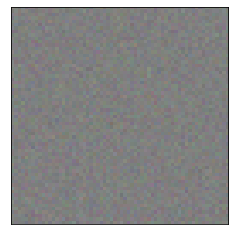

In [18]:
fixed_latent = Generate_Noise(batch_size, latent_size)
save_samples(0, fixed_latent)

In [19]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    #Lists to keep track of progress
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    #Create optimizers for the discriminator and generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(Train_DataLoader):
            # Train discriminator
            loss_d, real_score, fake_score = Discriminator_Training(real_images, opt_d)
            # Train generator
            loss_g = Generator_Training(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        latent = Generate_Noise(batch_size, latent_size)
        save_samples(epoch+start_idx, latent, show=True)

        # Save the model checkpoints 
        Discriminator_File = './Models/' + 'Discriminator_FC_CheckPoint_' + str(epoch+start_idx) + '.pth'
        Generator_File = './Models/' + 'Generator_FC_CheckPoint_' + str(epoch+start_idx) + '.pth'
        torch.save(generator.state_dict(), Discriminator_File)
        torch.save(discriminator.state_dict(), Generator_File)
    
    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 1.8596, loss_d: 0.9829, real_score: 0.6342, fake_score: 0.4099
Saving generated-images-FC-0001.png


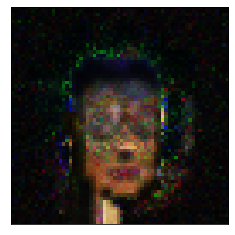

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 1.8022, loss_d: 1.8048, real_score: 1.0000, fake_score: 0.8355
Saving generated-images-FC-0002.png


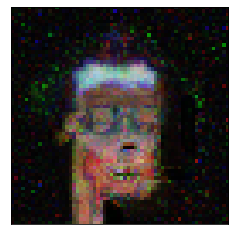

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.8309, loss_d: 1.0980, real_score: 0.5461, fake_score: 0.3892
Saving generated-images-FC-0003.png


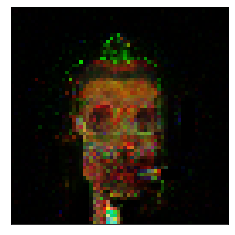

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 1.7934, loss_d: 1.3087, real_score: 0.4495, fake_score: 0.3990
Saving generated-images-FC-0004.png


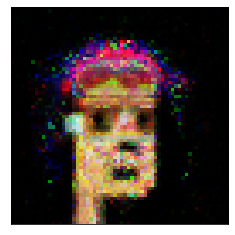

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 0.6830, loss_d: 1.2733, real_score: 0.5528, fake_score: 0.4937
Saving generated-images-FC-0005.png


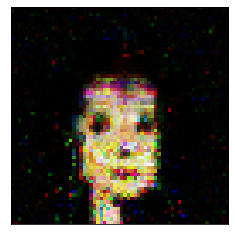

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 1.2671, loss_d: 1.9684, real_score: 0.2131, fake_score: 0.3446
Saving generated-images-FC-0006.png


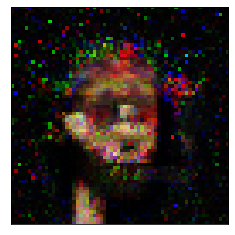

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 0.8731, loss_d: 1.1204, real_score: 0.3730, fake_score: 0.1256
Saving generated-images-FC-0007.png


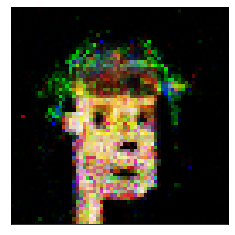

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 1.0832, loss_d: 1.6600, real_score: 0.3135, fake_score: 0.3935
Saving generated-images-FC-0008.png


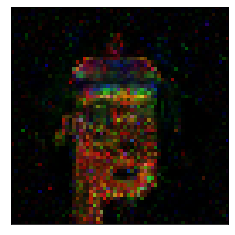

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 0.7187, loss_d: 1.4338, real_score: 0.3801, fake_score: 0.3727
Saving generated-images-FC-0009.png


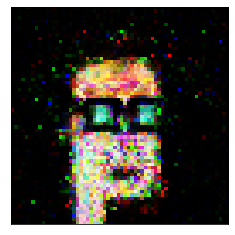

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 1.5456, loss_d: 1.7890, real_score: 0.2088, fake_score: 0.1996
Saving generated-images-FC-0010.png


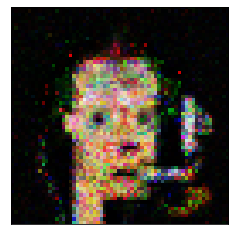

Training complete


In [20]:
lr = 0.0002
epochs = 10
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history
print("Training complete")

# Results, Generated Samples, Losses and Scores

In [21]:
def Display_Generated_Images(path):
    Image(path)
    plt.show()

Display_Generated_Images('./generated/generated-images-FC-0001.png')
Display_Generated_Images('./generated/generated-images-FC-0005.png')
Display_Generated_Images('./generated/generated-images-FC-0009.png')

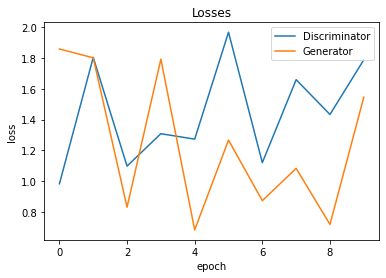

In [22]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.savefig('Losses_FC.png')
plt.show()

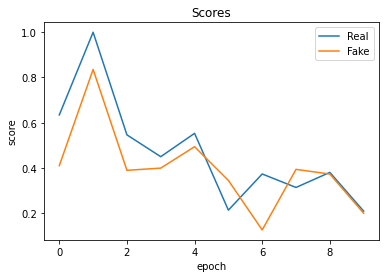

In [23]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.savefig('Scores_FC.png')
plt.show()